In [2]:
import os
import sys
sys.path.append('../dps')
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from dps import darkphoton
from dps.data import sort
from dps.fit import dcs

### Mass range

In [2]:
central = sort.sort("dcs/central")
uncertainty = sort.sort("dcs/uncertainty")

In [5]:
masses1 = np.array([a.M for a in central[0]])
masses2 = np.array([a.M for a in uncertainty[0]])

In [6]:
delta_masses = list()
for M in masses1:
    delta_masses.append(np.min(np.abs(masses2 - M)))

<IPython.core.display.Javascript object>


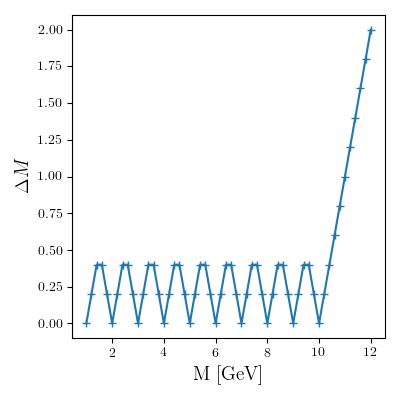

In [7]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(masses1, delta_masses, marker='+')

ax.set_xlabel("M [GeV]", fontsize=14)
ax.set_ylabel(r"$\Delta M$", fontsize=14)
ax.set(xscale='linear', yscale='linear')

plt.tight_layout()
plt.show()

### Fit error

In [3]:
uncertainty = sort.sort("dcs/uncertainty")
masses = [a.M for a in uncertainty[0]]

In [26]:
zcss = np.array([np.abs(x - y) for x, y in uncertainty[1][0]["css"]["pdf"]])
znlo = np.array([np.abs(x - y) for x, y in uncertainty[1][0]["nlo"]["pdf"]])
zdiv = np.array([np.abs(x - y) for x, y in uncertainty[1][0]["div"]["pdf"]])

<IPython.core.display.Javascript object>


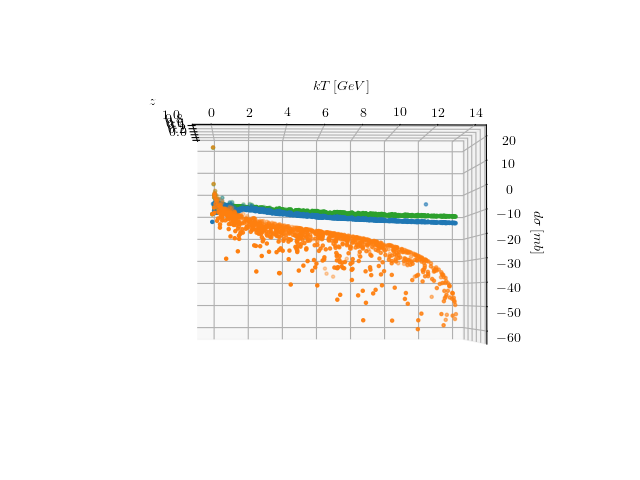

Text(0.5, 0, '$d\\sigma\\:[mb]$')

In [31]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(uncertainty[1][0]["z"], uncertainty[1][0]["kT"], np.log(zcss), marker='.')
ax.scatter(uncertainty[1][0]["z"], uncertainty[1][0]["kT"], np.log(znlo), marker='.')
ax.scatter(uncertainty[1][0]["z"], uncertainty[1][0]["kT"], np.log(zdiv), marker='.')

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$kT\:[GeV]$")
ax.set_zlabel(r"$d\sigma\:[mb]$")

In [7]:
def get_fits(args, res):
    
    f = dcs.DCS(args.M, dirname="dcs/central/clean")
    
    z = res["z"]
    kT = res["kT"]
    
    fits = dict()
    fits["css"] = f.css(z, kT)
    fits["nlo"] = f.nlo(z, kT)
    fits["div"] = f.div(z, kT)
    
    return fits, f

def get_error(args, res, fits, f, dsmin=1e-10, err_max=10):
    
    z = res["z"]
    kT = res["kT"]
    n = len(z)
    
    dic1 = dict()
    for key in fits.keys():
        
        if key == "css":
            kinds = ["pdf"]
        else:
            kinds = ["pdf", "scale"]

        dic2 = {"bad": {"pdf": {"z": list(), "kT": list()},
                        "scale": {"z": list(), "kT": list()}},
                "err": {"pdf": 0., "scale": 0.},
                "count": {"pdf": 0, "scale": 0},
                "ratio": {"pdf": 0, "scale": 0}}
        
        for i in range(n):
            
            if key == "css" and kT[i] > f.kT2(z[i]):
                pass
            
            elif key == "nlo" and kT[i] < f.kT1(z[i]):
                pass
        
            elif key == "div" and kT[i] < f.kT1(z[i]):
                pass
            
            elif key == "div" and kT[i] > f.kT2(z[i]):
                pass

            elif np.abs(res[key]["central"][i]) < dsmin:
                pass
            
            else:
                
                x = (fits[key][i] - res[key]["central"][i])
                    
                for kind in kinds:
                    dx = (res[key][kind][i][0] - res[key][kind][i][1])
                    e = np.abs(x / dx)

                    if e > err_max:
                        dic2["bad"][kind]["z"].append(z[i])
                        dic2["bad"][kind]["kT"].append(kT[i])
                    else:
                        dic2["err"][kind] += e
                        dic2["count"][kind] += 1
        
        for kind in kinds:
            if dic2["count"][kind] == 0:
                dic2["err"]["pdf"] = np.nan
                dic2["err"]["scale"] = np.nan
            else:
                dic2["err"]["pdf"] /= dic2["count"][kind]
                dic2["err"]["scale"] /= dic2["count"][kind]
            dic2["ratio"][kind] = float(dic2["count"][kind]) / n
            
        dic1[key] = dic2
        
    return dic1

#### dsmin

In [8]:
error = [{"pdf": {"css": list(), "nlo": list(), "div": list()},
          "scale": {"nlo": list(), "div": list()}} 
          for M in masses]
ratio = [{"pdf": {"css": list(), "nlo": list(), "div": list()},
          "scale": {"nlo": list(), "div": list()}} 
          for M in masses]

dsmin_tab = [10**i for i in range(-20, 0)]  
err_max = 1e5

for i, (args, res) in enumerate(zip(uncertainty[0], uncertainty[1])):
    
    print(i)
    
    fits, f = get_fits(args, res)
    
    for dsmin in dsmin_tab:
        
        dic = get_error(args, res, fits, f, dsmin=dsmin, err_max=err_max)

        for key in ["css", "div", "nlo"]:

            error[i]["pdf"][key].append(dic[key]["err"]["pdf"])
            ratio[i]["pdf"][key].append(dic[key]["ratio"]["pdf"])
            
        for key in ["div", "nlo"]:

            error[i]["scale"][key].append(dic[key]["err"]["scale"])
            ratio[i]["scale"][key].append(dic[key]["ratio"]["scale"])
    

0


/home/jonas/venv/3/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1
2


/home/jonas/Documents/DarkPhotonProduction/darkphoton-simulator/dps/utils.py:31: RuntimeWarning: invalid value encountered in true_divide
  onshell = xA * MT / M + kT**2 / _setup.S_beam / (1 -  xB * MT / M)
/home/jonas/Documents/DarkPhotonProduction/darkphoton-simulator/dps/utils.py:34: RuntimeWarning: invalid value encountered in less_equal
  cond2 = np.logical_and(M**2 / _setup.S_beam + eps <= onshell, onshell <= 1 - eps)


3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


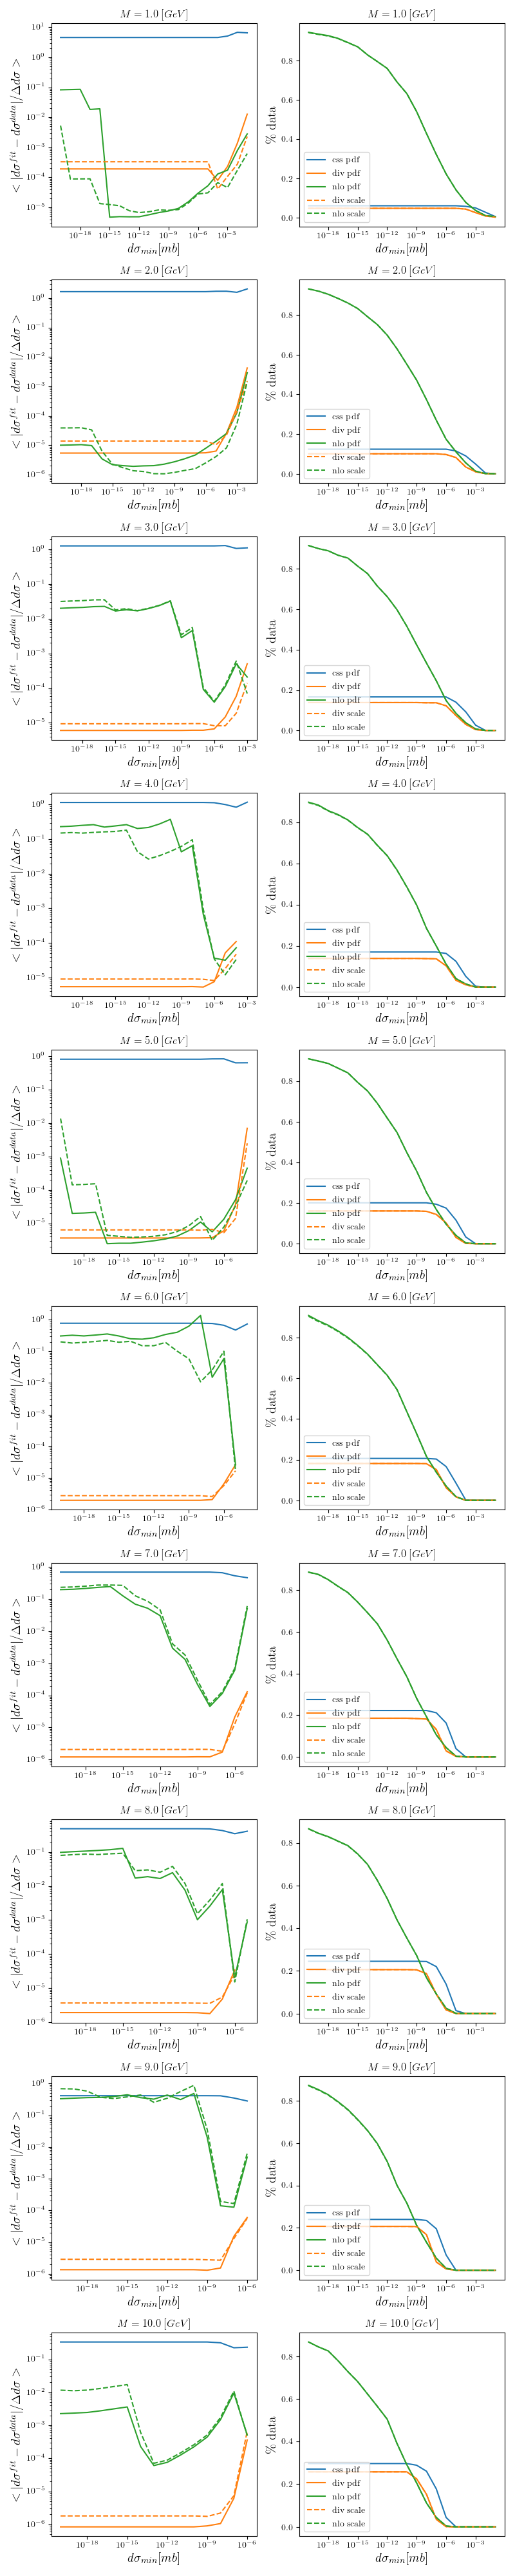

In [9]:
%matplotlib notebook

fig, ax = plt.subplots(10, 2, figsize=(8, 10 * 4))

for i in range(10):
    ax[i, 0].plot(dsmin_tab, error[i]["pdf"]["css"], '-', color="C0", label=r"css pdf")
    ax[i, 0].plot(dsmin_tab, error[i]["pdf"]["div"], '-', color="C1", label=r"div pdf")
    ax[i, 0].plot(dsmin_tab, error[i]["pdf"]["nlo"], '-', color="C2", label=r"nlo pdf")

    ax[i, 0].plot(dsmin_tab, error[i]["scale"]["div"], '--', color="C1", label=r"div scale")
    ax[i, 0].plot(dsmin_tab, error[i]["scale"]["nlo"], '--', color="C2", label=r"nlo scale")

    ax[i, 1].plot(dsmin_tab, ratio[i]["pdf"]["css"], '-', color="C0", label=r"css pdf")
    ax[i, 1].plot(dsmin_tab, ratio[i]["pdf"]["div"], '-', color="C1", label=r"div pdf")
    ax[i, 1].plot(dsmin_tab, ratio[i]["pdf"]["nlo"], '-', color="C2", label=r"nlo pdf")

    ax[i, 1].plot(dsmin_tab, ratio[i]["scale"]["div"], '--', color="C1", label=r"div scale")
    ax[i, 1].plot(dsmin_tab, ratio[i]["scale"]["nlo"], '--', color="C2", label=r"nlo scale")

    ax[i, 0].set_xlabel(r"$d\sigma_{min} [mb]$", fontsize=14)
    ax[i, 0].set_ylabel(r"$< |d\sigma^{fit} - d\sigma^{data}| / \Delta d\sigma >$", fontsize=14)

    ax[i, 1].set_xlabel(r"$d\sigma_{min} [mb]$", fontsize=14)
    ax[i, 1].set_ylabel(r"\% data", fontsize=14)
    
    ax[i, 0].set(xscale='log', yscale='log')
    ax[i, 1].set(xscale='log', yscale='linear')

    ax[i, 1].legend(loc="lower left")
    ax[i, 0].title.set_text(r"$M={}\:[GeV]$".format(masses[i]))
    ax[i, 1].title.set_text(r"$M={}\:[GeV]$".format(masses[i]))
    
plt.tight_layout()
plt.show()

#### $d\sigma_{min} = 10^{-9}$

In [12]:
dsmin = 1e-9
err_max = 1e5

dics = list()
for i, (args, res) in enumerate(zip(uncertainty[0], uncertainty[1])):
    
    fits, f = get_fits(args, res)
        
    dic = get_error(args, res, fits, f, dsmin=dsmin, err_max=err_max)
    dics.append(dic)

/home/jonas/venv/3/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/jonas/Documents/DarkPhotonProduction/darkphoton-simulator/dps/utils.py:31: RuntimeWarning: invalid value encountered in true_divide
  onshell = xA * MT / M + kT**2 / _setup.S_beam / (1 -  xB * MT / M)
/home/jonas/Documents/DarkPhotonProduction/darkphoton-simulator/dps/utils.py:34: RuntimeWarning: invalid value encountered in less_equal
  cond2 = np.logical_and(M**2 / _setup.S_beam + eps <= onshell, onshell <= 1 - eps)


<IPython.core.display.Javascript object>


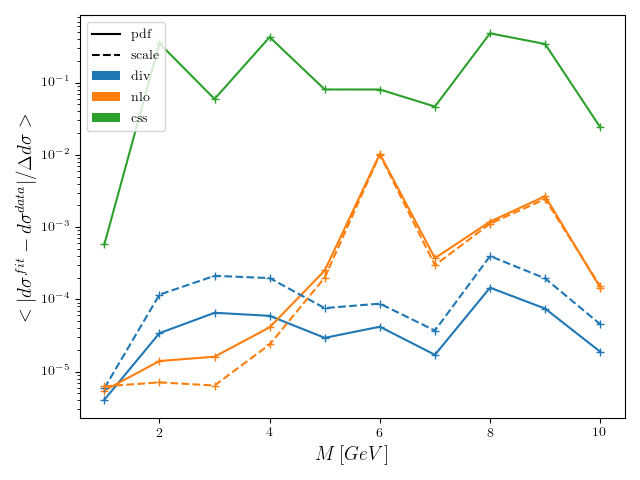

In [13]:
%matplotlib notebook

labels = [Line2D([0], [0], color="k", Linestyle='-', label=r"pdf"),
          Line2D([0], [0], color="k", Linestyle='--', label=r"scale"),
          Patch(facecolor='C0', label=r"div"),
          Patch(facecolor='C1', label=r"nlo"),
          Patch(facecolor='C2', label=r"css")]

fig, ax = plt.subplots()

for i, key in enumerate(["div", "nlo", "css"]):
    err = np.array([dic[key]["err"]["pdf"] for dic in dics])
    ax.plot(masses, err, color="C{}".format(i), marker="+", Linestyle="-")
    
for i, key in enumerate(["div", "nlo"]):
    err = np.array([dic[key]["err"]["scale"] for dic in dics])
    ax.plot(masses, err, color="C{}".format(i),marker="+", Linestyle="--")
    
ax.set_xlabel(r"$M\:[GeV]$", fontsize=14)
ax.set_ylabel(r"$< |d\sigma^{fit} - d\sigma^{data}| / \Delta d\sigma >$", fontsize=14)

ax.set(yscale='log')

plt.legend(handles=labels)
plt.tight_layout()
plt.show()

### Information loss

In [2]:
masses = np.linspace(1, 10, 10)

losses = {"inf": list(), "sup": list()}
for M in masses:
    f = dcs.DCS(M)
    loss_inf, loss_sup = f.information_loss()
    losses["inf"].append(loss_inf)
    losses["sup"].append(loss_sup)

/home/jonas/venv/3/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/jonas/Documents/DarkPhotonProduction/ship_dpf/dps/utils.py:27: RuntimeWarning: invalid value encountered in true_divide
  onshell = xA * MT / M + kT**2 / setup.S_beam / (1 -  xB * MT / M)
/home/jonas/Documents/DarkPhotonProduction/ship_dpf/dps/utils.py:30: RuntimeWarning: invalid value encountered in less_equal
  cond2 = np.logical_and(M**2 / setup.S_beam + eps <= onshell, onshell <= 1 - eps)


<IPython.core.display.Javascript object>


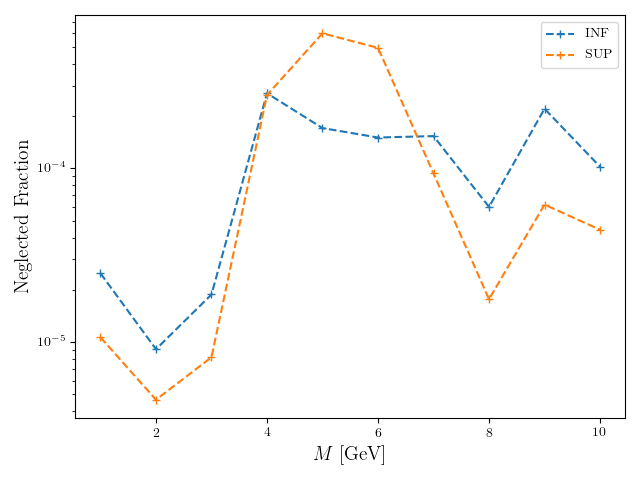

In [7]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(masses, losses["inf"], marker='+', Linestyle='--', label=r"INF")
ax.plot(masses, losses["sup"], marker='+', Linestyle='--', label=r"SUP")

ax.set_xlabel(r"$M$ [GeV]", fontsize=14)
ax.set_ylabel(r"Neglected Fraction", fontsize=14)

ax.set(xscale='linear', yscale='log')

plt.legend()
plt.tight_layout()
plt.show()